<a href="https://colab.research.google.com/github/nhwhite212/DealingwithDataSpring2021/blob/master/6-Pandas/B-Pandas_and_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Using Pandas together with SQL

### First install the relevant linux libraries

In [1]:
!sudo apt-get install -y python-dev libmysqlclient-dev && sudo pip install mysqlclient

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-dev is already the newest version (2.7.15~rc1-1).
libmysqlclient-dev is already the newest version (5.7.33-0ubuntu0.18.04.1).
libmysqlclient-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
     |████████████████████████████████| 92kB 3.7MB/s 
  Created wheel for mysqlclient: filename=mysqlclient-2.0.3-cp37-cp37m-linux_x86_64.whl size=100102 sha256=3757c857c6af09065491bcc2f3c01e154dab7a76b5acd183a1a020bd8b25101c
  Stored in directory: /root/.cache/pip/wheels/75/ca/e8/ad4e7ce3df18bcd91c7d84dd28c7c08db491a2a2360efed363
Successfully built mysqlclient


In [2]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (15, 5)

In [3]:
# Install the SQLAlchemy library if it is not installed
!sudo -H pip3 install -U sqlalchemy

     |████████████████████████████████| 1.5MB 5.3MB/s 
  Found existing installation: SQLAlchemy 1.4.7
    Uninstalling SQLAlchemy-1.4.7:
      Successfully uninstalled SQLAlchemy-1.4.7


### Importing into DataFrames using read_sql

The `read_sql` function of Pandas allows us to create a dataframe directly from a SQL query. To execute the query, we first setup the connection to the database using the SQLAlchemy library.

In [4]:
from sqlalchemy import create_engine

In [5]:
conn_string_imdb = 'mysql://{user}:{password}@{host}:{port}/{db}'.format(
    user='student', 
    password='dwdstudent2015', 
    host = 'db.ipeirotis.org', 
    port=3306, 
    db='imdb'
)
engine_imdb = create_engine(conn_string_imdb)

#### Retrieve the first 10 lines from the actors table 

In [6]:
query = '''
SELECT * FROM actors LIMIT 10
'''

#### Now issue that query with the read_sql dataframe method to create a DF from the table

In [8]:
df_actors = pd.read_sql(query, con=engine_imdb)

In [9]:
df_actors

,id,first_name,last_name,gender
0,2,Michael,'babeepower' Viera,M
1,3,Eloy,'Chincheta',M
2,4,Dieguito,'El Cigala',M
3,5,Antonio,'El de Chipiona',M
4,6,José,'El Francés',M
5,7,Félix,'El Gato',M
6,8,Marcial,'El Jalisco',M
7,9,José,'El Morito',M
8,10,Francisco,'El Niño de la Manola',M
9,11,Víctor,'El Payaso',M


#### Query to retrieve the number of movies per year

In [21]:
query = '''
SELECT year, COUNT(*) AS num_movies, COUNT(rating) AS rated_movies
FROM movies 
GROUP BY year
ORDER BY year;
'''

#### Issue the query using the pandas read_sql method. It returns a pandas dataframe. Note how we have used MYSQL to do the aggregation and sorting for us.

In [22]:
df_movies = pd.read_sql(query, con=engine_imdb)

In [23]:
df_movies.head(5)

,year,num_movies,rated_movies
0,1888,2,0
1,1890,3,1
2,1891,6,6
3,1892,9,9
4,1893,2,1


#### Let's try to plot the results.  The pandas plot method will pick some default settings for matplotlib.

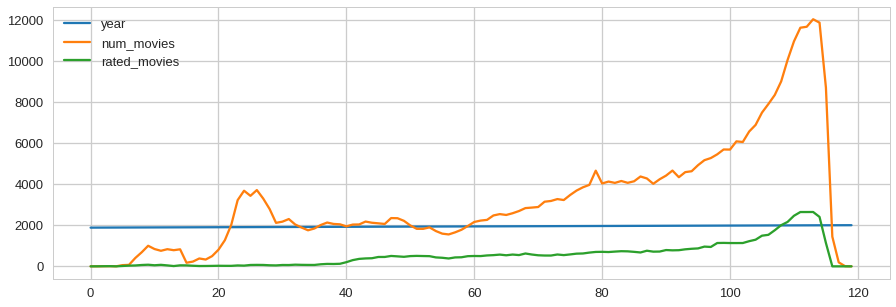

In [24]:
df_movies.plot()

We have a couple of issues. We also plotted the year as a line, and we do not have it as the label of the x-axis. For that, we need to convert the year into a proper datetime variable, and then make it the index for the dataframe.

In [25]:
df_movies['year'] = pd.to_datetime(df_movies['year'], format='%Y')
df_movies2 = df_movies.set_index('year')

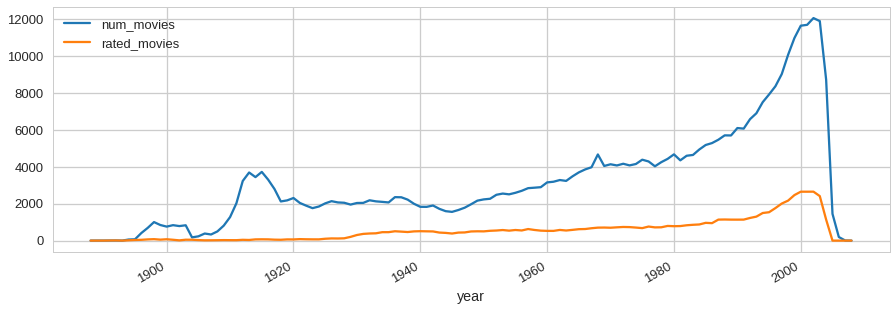

In [26]:
df_movies2.plot()

### Exercise

* Connect to the Facebook database, and use the `MemberSince` variable from the `Profiles` table to plot the growth of Facebook users.
* (_Learn something new_) Use the [cumsum()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.cumsum.html) function of Pandas and plot the total number of registered users over time.

In [27]:
# your code here

### Further Examples with SQL and Pandas

Now let's run a query to get the political views of Facebook users, broken down by gender.

In [28]:
conn_string_fb = 'mysql://{user}:{password}@{host}:{port}/{db}'.format(
    user='student', 
    password='dwdstudent2015', 
    host = 'db.ipeirotis.org', 
    port=3306, 
    db='facebook'
)
engine_fb = create_engine(conn_string_fb)

In [29]:
describeprofiles = '''
describe Profiles
'''
df=pd.read_sql(describeprofiles,con=engine_fb)
df

,Field,Type,Null,Key,Default,Extra
0,ProfileID,int(11),NO,PRI,None,
1,Name,varchar(255),YES,,None,
2,MemberSince,datetime,YES,,None,
3,LastUpdate,datetime,YES,,None,
4,School,varchar(255),YES,,None,
5,Status,varchar(255),YES,,None,
6,Sex,varchar(255),YES,,None,
7,Birthday,datetime,YES,,None,
8,AIM,varchar(255),YES,,None,
9,Website,varchar(255),YES,,None,


In [30]:
polviews_by_gender = '''
SELECT Sex,  PoliticalViews, COUNT(*) AS cnt 
FROM Profiles 
WHERE Sex IS NOT NULL AND PoliticalViews IS NOT NULL 
GROUP BY Sex, PoliticalViews  
ORDER BY  PoliticalViews, Sex
'''


And let's get the dataframe:

In [31]:
df = pd.read_sql(polviews_by_gender, con=engine_fb)
df

,Sex,PoliticalViews,cnt
0,Female,Apathetic,309
1,Male,Apathetic,462
2,Female,Conservative,428
3,Male,Conservative,474
4,Female,Liberal,4054
5,Male,Liberal,2196
6,Female,Libertarian,113
7,Male,Libertarian,196
8,Female,Moderate,1444
9,Male,Moderate,1379


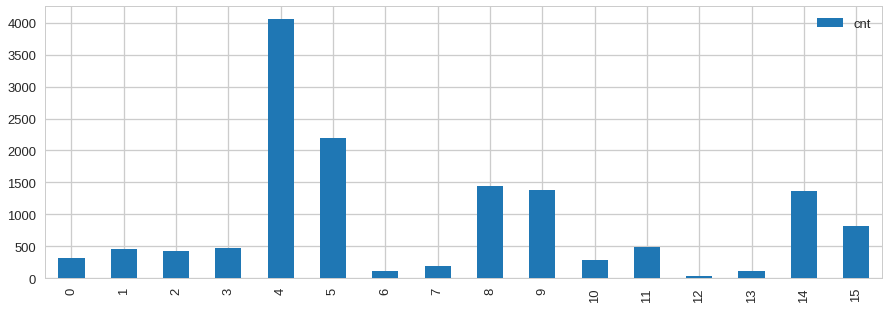

In [32]:
# Let's plot this!
# Bleh, this is really ugly...
# Remember that the index of the dataframe becomes the default x-axis
df.plot(kind='bar')

In [33]:
# Pivot, baby!
# Now the index contains the Political Views, which will be our x-axis
dfp = df.pivot_table(index='PoliticalViews', columns='Sex', values='cnt')
dfp

Sex,Female,Male
PoliticalViews,,
Apathetic,309,462
Conservative,428,474
Liberal,4054,2196
Libertarian,113,196
Moderate,1444,1379
Other,280,482
Very Conservative,38,107
Very Liberal,1362,813


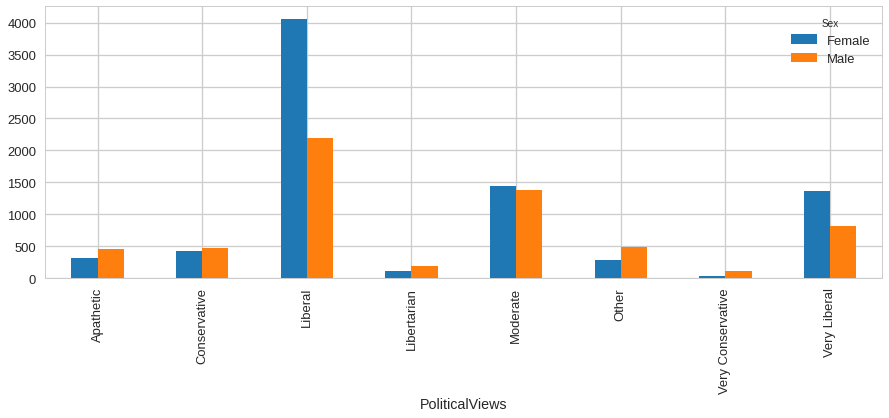

In [34]:
dfp.plot(kind='bar')

In [35]:
# Let's normalize the columns, as we have more females than males, and it seems that there are always more women
dfp = dfp / dfp.sum()
dfp

Sex,Female,Male
PoliticalViews,,
Apathetic,0.038490,0.075626
Conservative,0.053313,0.077590
Liberal,0.504983,0.359470
Libertarian,0.014076,0.032084
Moderate,0.179870,0.225733
Other,0.034878,0.078900
Very Conservative,0.004733,0.017515
Very Liberal,0.169656,0.133082


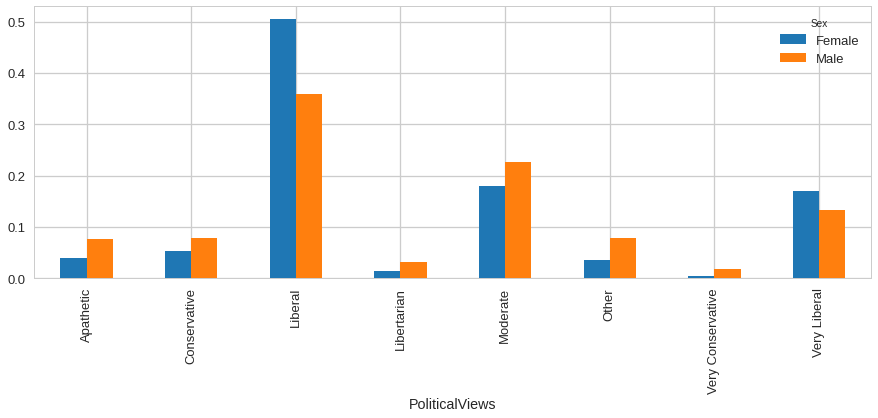

In [36]:
dfp.plot(kind='bar')

In [37]:
# OK, now let's try to re-order the list of results according to the logical structure
neworder = ['Very Liberal', 'Liberal', 'Moderate', 'Conservative', 'Very Conservative', 'Libertarian', 'Apathetic', 'Other']
newindex = sorted(dfp.index, key=lambda x: neworder.index(x))
dfp = dfp.reindex(newindex)
dfp

Sex,Female,Male
PoliticalViews,,
Very Liberal,0.169656,0.133082
Liberal,0.504983,0.359470
Moderate,0.179870,0.225733
Conservative,0.053313,0.077590
Very Conservative,0.004733,0.017515
Libertarian,0.014076,0.032084
Apathetic,0.038490,0.075626
Other,0.034878,0.078900


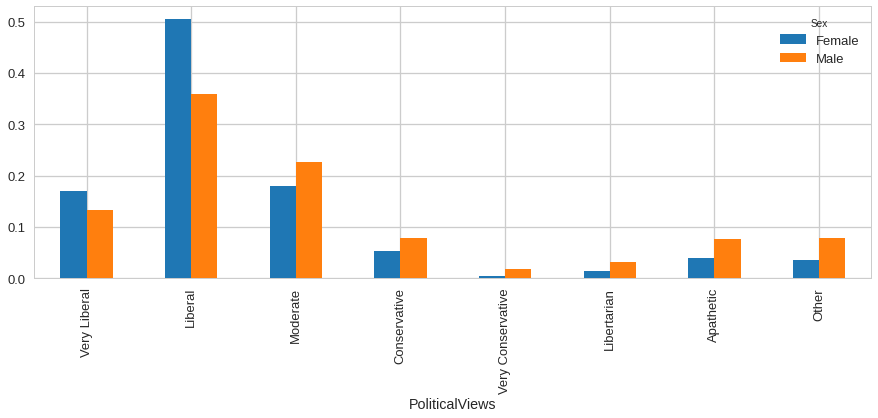

In [38]:
dfp.plot(kind='bar')

### Facebook, Favorite Books, and Political views

In [39]:
Fbooks= '''
describe FavoriteBooks
'''
df_fbooks = pd.read_sql(Fbooks, con=engine_fb)
df_fbooks.head(10)

,Field,Type,Null,Key,Default,Extra
0,ProfileID,int(11),NO,MUL,None,
1,Book,varchar(255),YES,,None,


In [40]:
books = '''
SELECT F.Book, P.PoliticalViews , COUNT(*) AS cnt 
FROM Profiles P JOIN FavoriteBooks F ON F.ProfileID = P.ProfileId  
WHERE PoliticalViews IS NOT NULL AND F.Book IS NOT NULL 
      AND (PoliticalViews = 'Liberal' OR PoliticalViews = 'Conservative')
GROUP BY F.Book, P.PoliticalViews
'''

In [41]:
df_books = pd.read_sql(books, con=engine_fb)
df_books.head(10)

,Book,PoliticalViews,cnt
0,Mansfield Park,Conservative,2
1,Memoirs Of A Geisha,Conservative,17
2,Harry Potter All,Conservative,1
3,A Gesture Life,Conservative,1
4,Queen Of Camelot,Conservative,1
5,Middlesex,Conservative,2
6,Cat S Cradle,Conservative,6
7,Diary,Conservative,2
8,The Bible,Conservative,21
9,And Online Blogs,Conservative,1


In [42]:
dfp = df_books.pivot_table(index='Book', columns='PoliticalViews', values='cnt')
dfp.head(10)

PoliticalViews,Conservative,Liberal
Book,,
000 In College Loans And A Meaningless Diploma Quot,NaN,1.0
000 Leagues Under The Sea,NaN,2.0
000 Things To Be Happy About,NaN,1.0
1,NaN,1.0
1 Bachelorette,NaN,1.0
10 Otherland 11 Wheel Of Time Series Ummm There Are More,NaN,1.0
10 Thousand Sorrows,NaN,1.0
100 Anos De Soledad,NaN,1.0
100 People Who Are Screwing Up America,1.0,NaN


In [43]:
# If we compute the sums, we will see that we have very different 
# number of likes per political view, due to imbalance in the population
dfp.sum()

PoliticalViews
Conservative     3318.0
Liberal         31253.0
dtype: float64

In [44]:
# Normalize the values, so that each column sums up to 1.0
dfp = dfp / dfp.sum()
dfp.head(20)

PoliticalViews,Conservative,Liberal
Book,,
000 In College Loans And A Meaningless Diploma Quot,NaN,0.000032
000 Leagues Under The Sea,NaN,0.000064
000 Things To Be Happy About,NaN,0.000032
1,NaN,0.000032
1 Bachelorette,NaN,0.000032
10 Otherland 11 Wheel Of Time Series Ummm There Are More,NaN,0.000032
10 Thousand Sorrows,NaN,0.000032
100 Anos De Soledad,NaN,0.000032
100 People Who Are Screwing Up America,0.000301,NaN


In [45]:
dfp["Liberal_To_Conservative"] = dfp["Liberal"]  / dfp["Conservative"] 
dfp["Conservative_To_Liberal"] = dfp["Conservative"]  / dfp["Liberal"] 

In [46]:
liberal_books = dfp[["Liberal_To_Conservative"]].sort_values("Liberal_To_Conservative", ascending=False).head(10)
liberal_books

PoliticalViews,Liberal_To_Conservative
Book,
The Kite Runner,6.582280
The Hours,6.157617
The Bluest Eye,5.414456
Love In The Time Of Cholera,5.308290
The Phantom Tollbooth,4.989793
The Unbearable Lightness Of Being,4.936710
Angels In America,4.883627
Middlesex,4.724378
Beloved,4.565130


In [47]:
conservative_books = dfp[["Conservative_To_Liberal"]].sort_values("Conservative_To_Liberal", ascending=False).head(10)
conservative_books

PoliticalViews,Conservative_To_Liberal
Book,
When Genius Failed,37.676914
Liar S Poker,33.909222
Exodus,18.838457
Anything By Nicholas Sparks,18.838457
Juiced,18.838457
French Women Don T Get Fat,18.838457
Fiasco,18.838457
Anything Dave Barry,18.838457
The Hardy Boys,18.838457


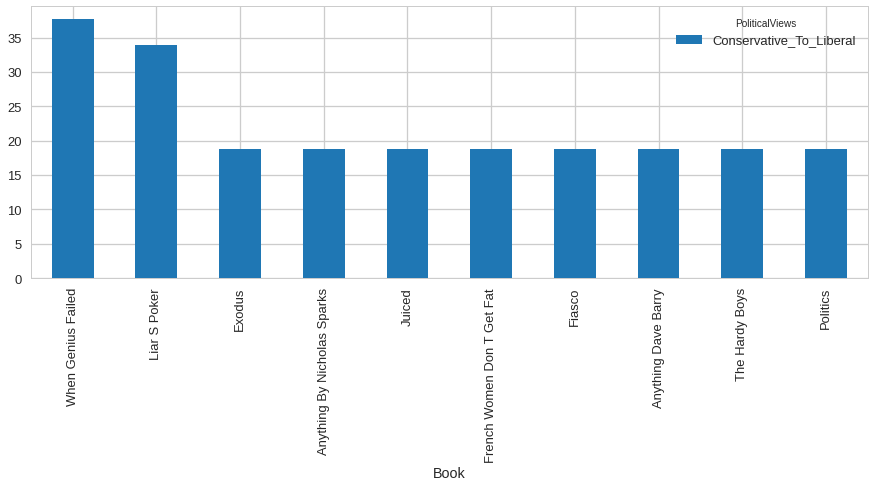

In [48]:
conservative_books.plot(kind='bar')

#   
# Inserting Data in a Database using Pandas
### WE NEED TO SWITCH TO THE BIGDATA SERVER for THIS
#    We also need to download a copy of the NYC Open Data 
#    Restaurant Inspections 

In [50]:
!curl http://people.stern.nyu.edu/nwhite/DealingwithDataSpring2021/data/restaurant.csv.gz  -o restaurant.csv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34.2M  100 34.2M    0     0   302k      0  0:01:56  0:01:56 --:--:--  302k


In [87]:
# Read the CSV file
restaurants = pd.read_csv('restaurant.csv.gz', encoding="utf-8", dtype="unicode")
restaurants.describe()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
count,394724,394084,394724,394476,394710,389154,394707,394724,394724,393220,388805,385566,385566,377579,199356,197928,394724,393220,394299,394299,388743,388743,388743,387030,394299,388743
unique,26979,21101,6,7288,3223,224,25342,84,1327,5,106,91,2,137,7,1254,1,32,22501,22501,69,51,1184,19585,19293,193
top,41669112,DUNKIN',Manhattan,1,BROADWAY,10003,7185958100,American,01/01/1900,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Y,12,A,06/13/2019,10/26/2019,Cycle Inspection / Initial Inspection,0,0,105,03,003800,4000000,1,MN17
freq,91,4021,154802,2246,14437,10408,274,82885,1504,368393,55692,55692,215906,40985,156686,525,394724,228967,5556,5556,31480,34450,3250,2474,3033,23156


In [88]:
# Usual bookkeeping regarding datatypes
restaurants["GRADE DATE"] = pd.to_datetime(restaurants["GRADE DATE"], format="%m/%d/%Y")
restaurants["RECORD DATE"] = pd.to_datetime(restaurants["RECORD DATE"], format="%m/%d/%Y")
restaurants["INSPECTION DATE"] = pd.to_datetime(restaurants["INSPECTION DATE"], format="%m/%d/%Y")
restaurants["SCORE"] = pd.to_numeric(restaurants["SCORE"])
restaurants["BORO"] =  pd.Categorical(restaurants["BORO"], ordered=False)
restaurants["GRADE"] =  pd.Categorical(restaurants["GRADE"], categories = ['A', 'B', 'C'], ordered=True)
restaurants["VIOLATION CODE"] =  pd.Categorical(restaurants["VIOLATION CODE"], ordered=False)
restaurants["CRITICAL FLAG"] =  pd.Categorical(restaurants["CRITICAL FLAG"], ordered=False)
restaurants["ACTION"] =  pd.Categorical(restaurants["ACTION"], ordered=False)
restaurants["CUISINE DESCRIPTION"] =  pd.Categorical(restaurants["CUISINE DESCRIPTION"], ordered=False)

In [89]:
# Connect to the MySQL, but without selecting a database
# I will use the class userid and password for testing
#

conn_string = 'mysql://{user}:{password}@{host}:{port}/'.format(
    user='DealingS21', password='DealingS21!!', 
    host = 'bigdata.stern.nyu.edu', port=3306)
engine = create_engine(conn_string)

In [90]:
# Create the database where we want to store the data
# Do not worry about the Warning if the database already exists
engine.execute('CREATE DATABASE IF NOT EXISTS nyc_restaurant_inspections')
engine.execute('USE nyc_restaurant_inspections')

In [91]:
# We drop the table if it is already there
engine.execute('DROP TABLE inspections1000')


OperationalError: ignored

## BEWARE the to_sql pandas method is VERY SLOW!!!
#### I ran this code and created an inspections table, which I will keep
#### It took 14 minutes to load all 394000 rows, so for class I will  only load
#### 1000 as an example. I am keeping the full inspections table for example queries,


In [92]:
# Lets create a small table to test, since insertions are very slow
# Takes over 10 minutes to insert all of the restaurant data

restaurants1000=restaurants.head(1000)

In [94]:
# Store the dataframe as a SQL table, using the to_sql command
# This command is very slow, so this can take a while
restaurants1000.to_sql(name='inspections1000', if_exists='replace', index=False, con=engine, chunksize=500)

In [95]:
# And then we can just retrieve it from the database
df = pd.read_sql("SELECT * FROM inspections1000 LIMIT 100", con=engine)
df.head(5)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,40638039,LEGENDS BAR & GRILL,Queens,7104,35 AVENUE,11372,7188999553,American,2019-03-25,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Y,10.0,A,2019-03-25,2019-10-26,Cycle Inspection / Initial Inspection,40.750719368488,-73.894733598464,403,25,029100,4029524,4012710101,QN28
1,40577241,ROYAL BAKERY & ROTI SHOP,Brooklyn,618,NOSTRAND AVENUE,11216,7186040200,Caribbean,2017-02-27,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,9.0,A,2017-02-27,2019-10-26,Cycle Inspection / Initial Inspection,40.677323126922,-73.949811619041,308,36,031500,3030003,3012060041,BK61
2,50057781,BENS COOKIES,Manhattan,822,BROADWAY,10003,5164106172,Café/Coffee/Tea,2016-12-20,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,8.0,A,2016-12-20,2019-10-26,Pre-permit (Operational) / Initial Inspection,40.733033400166,-73.991138128793,102,02,006100,1009001,1005570017,MN23
3,40542546,CUCCIOS BAKERY,Brooklyn,320,AVENUE X,11223,7183361944,Bakery,2017-12-19,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,23.0,None,NaT,2019-10-26,Cycle Inspection / Initial Inspection,40.590414238221,-73.971289470632,315,47,037402,3195080,3071940010,BK26
4,41383250,OSAKA JAPANESE FUSION,Queens,2524,BROADWAY,11106,7187772662,Japanese,2016-10-05,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,11.0,A,2016-10-05,2019-10-26,Cycle Inspection / Re-inspection,40.76329423995,-73.928209921765,401,22,005300,4007160,4005800026,QN70


In [96]:
### How many rows do we have?
df1= pd.read_sql('select count(*) from inspections1000',con=engine)
df1

,count(*)
0,1000


In [97]:
### How about in the full table? 
df1=pd.read_sql('select count(*) from inspections',con=engine)
df1

,count(*)
0,394724


# In class exercise
####   
### Connect to the mysql server on bigdata.stern.nyu.edu
#### using your team userid and password

#### Just copy the cell above, and use your team userid and password
##### DealingS21GBx   DealingFS21GBx!!   
#### Use your team database (DealingS21GBx)
####  
#### Create a table named  ("yournetid) in your team database. It should have two 
#### attributes, a and b, both ints
#### i.e.
##### create table nhw1 (a int, b int);
##### insert into yournetid(a,b) values(1,2);  
#### and 3,4 in the first two rows.
#### select * from the table into a dataframe
#### print it.
#### drop the table

In [98]:
# create a small data frame
data=[[1,2],[3,4],[5,6]]
mydf=pd.DataFrame(data,columns=['a','b'])
mydf


,a,b
0,1,2
1,3,4
2,5,6


In [104]:
# Your code here (Change the user and password)
# Connect to the MySQL, but without selecting a database
# I will use team 10's userid and password for testing
#

conn_string = 'mysql://{user}:{password}@{host}:{port}/'.format(
    user='DealingS21GB10', password='DealingS21GB10!!', 
    host = 'bigdata.stern.nyu.edu', port=3306)
engine = create_engine(conn_string)

engine.execute("USE DealingS21GB10")

engine.execute("SHOW TABLES")
engine.execute("DROP TABLE IF EXISTS  nhw1")
# create a table for the data frame

mydf.to_sql(name='nhw1', index=False, con=engine, chunksize=500)

engine.execute("SHOW TABLES")

In [105]:
engine.execute("USE DealingS21GB10")
df = pd.read_sql("SELECT * FROM nhw1 LIMIT 100", con=engine)
df.head(5)
res=pd.read_sql("SHOW TABLES", con=engine)
res
engine.execute("DROP TABLE nhw1")

In [106]:
df

,a,b
0,1,2
1,3,4
2,5,6


In [107]:
res

,Tables_in_DealingS21GB10
0,nhw1


# That should get you started on using mysql and Pandas